# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [27]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [28]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

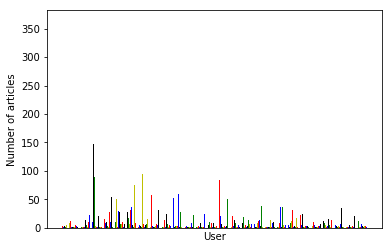

In [3]:
tmp = df.groupby(['email']).count()

# Plotting the distribution of how many articles a user interacts with in the dataset
x_data = tmp.index
y_data = tmp['article_id']
plt.xlabel('User')
plt.ylabel('Number of articles')
plt.xticks([])
plt.bar(x_data, y_data, color=['k', 'r', 'g', 'b', 'y'])
plt.show()

In [29]:
# Fill in the median and maximum number of user_article interactios below
df.groupby(['email']).count()['article_id'].describe()
median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [30]:
# Find and explore duplicate articles
df_content['article_id'][df_content['article_id'].duplicated(keep= False)]

50      50
221    221
232    232
365     50
399    398
578    577
692    221
761    398
970    577
971    232
Name: article_id, dtype: int64

In [31]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset ="article_id", 
                     keep = 'first', inplace = True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [32]:
# The number of unique articles that have at least one interaction
df['article_id'].nunique()

# The number of unique articles on the IBM platform
df_content['article_id'].nunique()

# The number of unique users
df['email'].nunique()

# The number of user-article interactions
df.shape[0]

45993

In [33]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [35]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [36]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [72]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [38]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    tmp = df.groupby('title').count() # Counting instances
    
    top_articles = tmp.sort_values(['user_id'], ascending = False).head(n).index
    # Sorting and getting the top_articles titles with n_values
        
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    # Using the previous function to get top article names (with the value of n)
    top_article_names = get_top_articles(n)
    
    # Getting the titles in df in the top_article_names variable and Removing the duplicates
    top_article_names = df[df['title'].isin(top_article_names)].drop_duplicates(subset = 'title',
                                                                               keep = 'first')
    # Getting the ids of the top_articles as required
    top_articles = top_article_names['article_id']
 
    return top_articles # Return the top article ids

In [39]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')
1      1314.0
2      1429.0
14     1170.0
29     1364.0
31     1162.0
37     1431.0
42     1427.0
56     1304.0
66     1330.0
154    1293.0
Name: article_id, dtype: float64


In [73]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [47]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_copy = df.copy() # Copying the original df to later edit the copied df
    df_copy['tmp_col'] = 1 # Adding a column of 1's for the values in the user_item_matrix
    df_copy = df_copy[['user_id', 'article_id', 'tmp_col']] # Getting the required cols
    
    # Generating the user item matrix
    user_item = df_copy.groupby(['user_id', 'article_id'])['tmp_col'].max().unstack(fill_value = 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [74]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [51]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    users_similarity = user_item.loc[user_id, :].dot(np.transpose(user_item))
    # sort by similarity
    users_similarity_sorted = users_similarity.sort_values(ascending = False)
    # create list of just the ids
    similar_users_ids = users_similarity_sorted.index
    # remove the own user's id
    most_similar_users = users_similarity_sorted.loc[(users_similarity_sorted.index != user_id)].index.values.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar

In [75]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [53]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code her
    
    # Using list Comprehension technique we get article names of articles_ids given
    article_names = [df[df['article_id'] == float(article_id)]['title'].values[0] for article_id in article_ids]
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    # Mapping the ids to be a string for the testing and get them in article_ids variable as a list
    article_ids = list(map(str,(user_item.loc[user_id][user_item.loc[user_id] == 1].index.values.tolist())))
    
    # Getting the article names ('titles') as list of the article_ids and dropping duplicates
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().values.tolist() 
    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id ><><>Similarity<><><
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    # Getting the articles read by the user
    usr_seen_ids, usr_seen_names = get_user_articles(user_id, user_item = user_item)
    
    # Getting the similar users for our user
    similar_users = find_similar_users(user_id)
    
    recs = list()
    
    for user in similar_users:
    # In this loop we add the recommendation if: 
        # 1) The user didn't see it before
        # 2) recommended by other users
    # Untill we reach certain number of recommendations given here as (m)
        sim_usr_article_ids, sim_usr_article_names = get_user_articles(user)

        for article_id in sim_usr_article_ids:
            if article_id not in usr_seen_ids:
                recs.append(article_id)

            if len(recs) >= m:
                break

        if len(recs) >= m:
            break

    if len(recs) < m:
        for arb_article_id in df['article_id'].values.tolist():
            if (arb_article_id not in usr_seen_ids) and (arb_article_id not in recs):
                recs.append(arb_article_id)
            if len(recs) >= m:
                break
   
    return recs # return your recommendations for this user_id    

In [76]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [77]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [64]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    # Getting the similar users for our user
    similar_users = find_similar_users(user_id)
    
    # Getting the user array
    user_arr = np.array(user_item.loc[user_id].values)
    
    # Lists to append to in the for loop
    similarity_lst = list()
    num_of_interact_lst = list()
    
    for user in similar_users:
        # Getting the similar user array user by user in the for loop
        sim_user_arr = np.array(user_item.loc[user].values)
        
        #Computing Similarity
        similarity_lst.append(np.dot(user_arr, sim_user_arr))
        
        #Computing Num of interactions
        num_of_interact_lst.append(user_item.loc[user].values.sum())
        
        #Creating the required df
    neighbors_df = pd.DataFrame({'neighbor_id' : similar_users,
                                 'similarity' : similarity_lst,
                                 'num_interactions': num_of_interact_lst}) 
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    recs = []
    
    # Using the previous recommendation functio logic with adding the idea of
    # 1) Recommendations from user with most article interactions
    # 2) Recommendations for the most recommended article by our users 
    
    # Getting the user articles
    usr_seen_ids, usr_seen_names = get_user_articles(user_id, user_item = user_item)
    
    # The top users df sorted by num_interactions with articles
    top_users_df = get_top_sorted_users(user_id).sort_values(by = ['num_interactions'], ascending = False)
    
    # set the index to be compatible with the new df
    top_users_df = top_users_df.set_index(top_users_df['neighbor_id'])
    
    # If the user is found in our dataframe
    if user_id not in top_users_df['neighbor_id']:
        for neighbor_id in top_users_df['neighbor_id'].values.tolist():

            # Read articles by neighbor
            neighbour_article_ids, neighbour_article_names = get_user_articles(neighbor_id)
            
            # Get the articles not read by user
            for article_id in neighbour_article_ids:
                if article_id not in usr_seen_ids:
                    recs.append(article_id)

                if len(recs) >= m:
                    break

            if len(recs) >= m:
                break

            if len(recs) < m:
                for article_id in [str(article_id) for article_id in get_top_article_ids(400)]:
                    if article_id not in usr_seen_ids:
                        recs.append(article_id)

                    if len(recs) >= m:
                            break

            if len(recs) >= m:
                break
    
    # If the user is NOT found in our dataframe (recommend most read articles)
    else:
        recs = get_top_article_ids(m)
        
    # Getting the article names of our recommendations
    rec_names = get_article_names(recs)

    
    return recs, rec_names

In [78]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['2.0', '12.0', '14.0', '16.0', '26.0', '28.0', '29.0', '33.0', '43.0', '50.0']

The top 10 recommendations for user 20 are the following article names:
['this week in data science (april 18, 2017)', 'timeseries data analysis of iot events by using jupyter notebook', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'higher-order logistic regression for large datasets', 'using machine learning to predict parking difficulty', 'deep forest: towards an alternative to deep neural networks', 'experience iot with coursera', 'using brunel in ipython/jupyter notebooks', 'deep learning with tensorflow course by big data university', 'graph-based machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [82]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [83]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

---------------------------------------
**Answer:**

For a new user, in my opinion is to use <code>get_top_articles</code> function since we don't have any
previous information regarding the user preferences so could recommend most popular articles.

A better method might by using the user personal info (age, level of education, geners liked) so we could then recommend articles that're more related to his personality

----------------------------------------

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [84]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(x) for x in get_top_article_ids(10)] # Your recommendations here

In [85]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [86]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [89]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [90]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices = True) # use the built in to get the three matrices

---------------------------------------------
**Answer:**

It worked using SVD because we don't have any missing values (nan), that's why it's different than the lesson with the user-movie matrix as it contained nan values (where we then used FunkSVD by Simon Funk).

---------------------------------------------

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

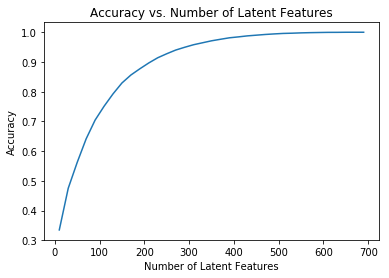

In [91]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [178]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    # Train data user item matrix
    df_train_cpy = df_train.copy()
    df_train_cpy['tmp_col'] = 1
    user_item_train = df_train_cpy.groupby(['user_id', 'article_id'])['tmp_col'].max().unstack(fill_value = 0)
    
    # Test data user item matrix
    df_test_cpy = df_test.copy()
    df_test_cpy['tmp_col'] = 1
    user_item_test = df_test_cpy.groupby(['user_id', 'article_id'])['tmp_col'].max().unstack(fill_value = 0)
    
    test_idx = user_item_test.index # add .tolist() if we require o/p as list
    test_arts = user_item_test.columns # add .tolist() if we require o/p as list
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [215]:
# Getting info for answering
test_idx
train_idx = user_item_train.index
train_arts = user_item_train.columns

# 1st Quest:
s = []
for i in train_idx:
    if i in test_idx:
        s.append(i)
    
len(s)

20

In [190]:
# 2nd Question:
s = []
for i in test_idx:
    if i not in train_idx:
        s.append(i)
len(s)

662

In [191]:
# 3rd Question
s = []
for i in test_arts:
    if i in train_arts:
        s.append(i)
len(s)

574

In [192]:
# 4th Question
user_item_test.shape[1] - 574 # 574 is the 3rd question answer

0

In [197]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?' : d
}

t.sol_4_test(sol_4_dict)

# The articles gave an error so I changed it for movies

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [129]:
# fit SVD on the user_item_train matrix

# Since we do not have any nan values in our data (avoided previous in the code with (fill_value = 0))
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices = True) # fit svd similar to above then use the cells below

In [201]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# converting the S, V, D shapes for the dot product
u_new = u_train[:, :len(s_train)]
s_new = np.diag(s_train[:len(s_train)])
print('Number of possible latent features:',u_new.shape[1]) # -- 714 num of latent features possible
u_new.shape, s_new.shape, vt_train.shape # -- returns ((4487, 714), (714, 714), (714, 714))

# Computing the dot product
pred_ratings = np.dot(np.dot(u_new, s_new), vt_train)

# Computing the squared error for each prediction vs. actual prediction
sum_square_errs = np.sum(np.sum((user_item_train - pred_ratings) ** 2))
print('The sum squared errors =', sum_square_errs)

Number of possible latent features: 714
The sum squared errors = 2.65179326366e-25


In [235]:
# Getting common users
common_users_idx = test_idx.isin(train_idx)

# Getting common articles
common_articles_idx = test_arts.isin(train_arts)

In [236]:
u_test = u_train[common_users_idx, :]
vt_test = vt_train[:, common_articles_idx]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4487 but corresponding boolean dimension is 682
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 714 but corresponding boolean dimension is 574
  


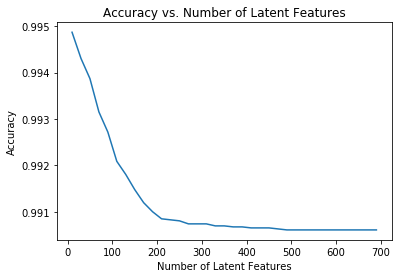

In [237]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
test_sum_errs = []

# Reusing the previous given code edited for the test matrix
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    user_test_item_est = np.around(np.dot(np.dot(u_new_test, s_new), vt_new_test))
    
    # compute error
    diffs_test = np.subtract(user_item_test.loc[user_item_matrix.loc[common_user_idx, :].index, :],
                             user_test_item_est)
    
    # total errors and keep track of them  
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    # Appending to the test_sum_errs list
    test_sum_errs.append(err_test)
    
plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

-----------------------------------------
**Answer:**

using SVD is huge improvement for better recommendations as now we can use the latent features to make our recommendations more related to the user depending on the latent feautres of the items the user have already seen

Also we could use A/B Testing to engage our users in the process and check the performance of our model (more reads, more users and so on...)

-----------------------------------------